# Calculating Individual Slopes

This code was created to add more detailed analysis to our study.

To run this code, you need the following files in the appropriate folders
 - Data/Input_files
   > Master_ADWR_database_noduplicates.shp <br>
   > Master_ADWR_database_water.shp
 - Data/Output_files
   > Wells55_GWSI_WLTS_DB_annual_updated.csv
 - Data/Shapefiles
   > Any shapefiles of your choosing

In [1]:
# Packages and paths
# %%
from optparse import Values
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.colors import ListedColormap
import datetime
from matplotlib.transforms import Bbox
import numpy as np
import pandas as pd
from shapely.geometry import box
import geopandas as gp
#import earthpy as et
import scipy.stats as sp
from scipy.stats import kendalltau, pearsonr, spearmanr
import pymannkendall as mk
import Custom_functions as cf

# Local paths
datapath_local = '../Data'
inputpath_local = '../Data/Input_files'
outputpath_local = '../Data/Output_files/'
shapepath_local = '../Data/Shapefiles/'
figurepath = '../Data/Figures/'

# Some functions
def kendall_pval(x,y):
        return kendalltau(x,y)[1]
    
def pearsonr_pval(x,y):
        return pearsonr(x,y)[1]
    
def spearmanr_pval(x,y):
        return spearmanr(x,y)[1]

# Function to calculate slope using linear regression
def calculate_slope(y):
    x = np.arange(len(y))
    slope, _ = np.polyfit(x, y, 1)
    return slope

In [2]:
# Creating Colors to Match Map
cap = '#C6652B'
# noCAP = '#EDE461' # This is one from the map but it's too bright and hard to see
noCAP = '#CCC339' # This color but darker for lines
GWdom = '#3B76AF'
mixed = '#6EB2E4'
swdom = '#469B76'
specialyears = 'darkgray'

cblind =["#000000","#004949","#009292","#ff6db6","#ffb6db",
 "#490092","#006ddb","#b66dff","#6db6ff","#b6dbff",
 "#920000","#924900","#db6d00","#24ff24","#ffff6d"]

### For calculating Individual Slopes

In [3]:
# Read in the main Static Database

filename_mdb_nd = 'Master_ADWR_database_noduplicates.shp'
filepath = os.path.join(outputpath_local, filename_mdb_nd)
print(filepath)

masterdb = gp.read_file(filepath)
pd.options.display.float_format = '{:.2f}'.format
print(masterdb.info())

../Data/Output_files/Master_ADWR_database_noduplicates.shp
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 250870 entries, 0 to 250869
Data columns (total 72 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   Combo_ID    250870 non-null  object  
 1   SITE_ID     45565 non-null   object  
 2   LOCAL_ID    45565 non-null   object  
 3   REGISTRY_I  229717 non-null  object  
 4   WELL_TYPE   45565 non-null   object  
 5   DD_LAT      45565 non-null   float64 
 6   DD_LONG     45565 non-null   float64 
 7   WELL_ALT    45565 non-null   float64 
 8   WATER_USE_  45507 non-null   object  
 9   WELL_DEPTH  221075 non-null  float64 
 10  CASE_DIAM   45565 non-null   float64 
 11  LASTWLDATE  34356 non-null   object  
 12  WL_DTW      45565 non-null   float64 
 13  WL_ELEV     45565 non-null   float64 
 14  QUASI_IDX_  11 non-null      object  
 15  GOES_ENABL  171 non-null     object  
 16  TRANSDUCER  171 non-null     object  
 17  

In [4]:
# Read in the annual time series database
# filename_ts = 'Wells55_GWSI_WLTS_DB_annual_updated_thresh15.csv'
filename_ts = 'Wells55_GWSI_WLTS_DB_annual_updated.csv'
filepath = os.path.join(outputpath_local, filename_ts)
print(filepath)
annual_db = pd.read_csv(filepath, header=1, index_col=0)

annual_db = annual_db[1:168102]
annual_db.index.astype('int64')
annual_db2 = annual_db.reset_index(inplace=True)
annual_db2 = annual_db.rename(columns = {'year':'Combo_ID'})
annual_db2 = annual_db2.set_index('Combo_ID')
annual_db2.head()

../Data/Output_files/Wells55_GWSI_WLTS_DB_annual_updated.csv


C:\Users\det19\AppData\Local\Temp\ipykernel_14804\1400479368.py:6: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  annual_db = pd.read_csv(filepath, header=1, index_col=0)


,1853.0,1856.0,1857.0,1860.0,1864.0,1868.0,1870.0,1871.0,1872.0,1873.0,...,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0,2020.0,2021.0,2022.0,2023.0
Combo_ID,,,,,,,,,,,,,,,,,,,,,
60001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,503.90,497.70,495.30,NaN,489.85,NaN,487.85,485.10,483.50,NaN
83578,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
84067,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
84442,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
84455,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# %% Creating slopes for individual wells
# Enter min year and max year of timeframe
minyear = 1975
maxyear = 2022

# %% Figure out which water level database you want
cat_wl2 = annual_db2.copy()
cat_wl2 = cat_wl2.transpose()
cat_wl2 = cat_wl2.reset_index()
cat_wl2['index'] = pd.to_numeric(cat_wl2['index'], errors='coerce')
cat_wl2.index = cat_wl2.index.astype('int64')
cat_wl2 = cat_wl2.set_index('index')

cat_wl2
# Water Analysis period
wlanalysis_period_AZ = cat_wl2[(cat_wl2.index>=minyear)&(cat_wl2.index<=maxyear)]
wlanalysis_period_AZ

Combo_ID,60001,83578,84067,84442,84455,84460,84598,84614,84626,84630,...,365929112580801,365929112582701,365942111292501,365945111293601,365947109220001,365952111294701,370006111300401,370058110175801,370119110181401,370120113555201
index,,,,,,,,,,,,,,,,,,,,,
1975.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,38.00,90.08,NaN,NaN,NaN,94.77,NaN,NaN,NaN
1976.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,83.42,NaN,NaN,NaN,84.77,NaN,NaN,NaN
1977.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,93.42,NaN,NaN,NaN,96.23,NaN,NaN,NaN
1978.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,104.67,NaN,NaN,NaN,103.90,NaN,NaN,NaN
1979.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,81.80,NaN,NaN,72.97,86.84,NaN,NaN,NaN
1980.00,NaN,12.00,0.00,0.00,120.00,150.00,NaN,12.00,280.00,18.00,...,NaN,NaN,60.69,NaN,NaN,NaN,63.59,NaN,NaN,NaN
1981.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,65.38,NaN,NaN,68.49,63.72,NaN,NaN,NaN
1982.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,64.51,NaN,NaN,NaN,62.46,NaN,NaN,NaN
1983.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,47.91,NaN,NaN,NaN,49.52,NaN,NaN,NaN


In [6]:
df = wlanalysis_period_AZ.copy()
wellcounts = df.count()
threshold = 15
well_threshold = wellcounts[wellcounts >= threshold].index
narrowed_df = df[well_threshold]
narrowed_df

Combo_ID,60001,85358,85598,85761,85799,85863,85970,86158,86280,86642,...,364338110154601,364908109525301,365403112452801,365557111295701,365611111294301,365631111281701,365704111250201,365942111292501,370006111300401,370119110181401
index,,,,,,,,,,,,,,,,,,,,,
1975.00,NaN,NaN,NaN,41.20,NaN,NaN,NaN,NaN,NaN,147.80,...,95.58,NaN,80.40,642.68,460.42,219.69,111.64,90.08,94.77,NaN
1976.00,NaN,NaN,NaN,40.70,NaN,NaN,NaN,NaN,NaN,157.35,...,96.15,NaN,80.00,613.86,439.14,209.35,103.11,83.42,84.77,NaN
1977.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,105.94,NaN,81.10,590.50,423.08,208.47,109.88,93.42,96.23,NaN
1978.00,NaN,NaN,NaN,40.40,NaN,NaN,NaN,NaN,NaN,163.20,...,105.53,NaN,NaN,572.04,416.08,220.36,124.00,104.67,103.90,NaN
1979.00,NaN,NaN,NaN,40.10,NaN,NaN,NaN,NaN,NaN,167.20,...,105.23,NaN,81.00,558.47,409.75,214.47,112.16,81.80,86.84,NaN
1980.00,NaN,NaN,700.00,39.68,100.00,50.00,120.00,NaN,36.00,159.60,...,107.26,NaN,79.90,542.30,395.67,192.32,84.52,60.69,63.59,NaN
1981.00,NaN,207.00,NaN,39.20,66.60,NaN,130.77,NaN,36.09,165.75,...,128.62,NaN,79.20,527.45,381.93,185.19,83.66,65.38,63.72,NaN
1982.00,NaN,NaN,564.70,NaN,76.25,NaN,NaN,130.00,36.77,170.60,...,117.53,NaN,81.70,514.34,376.41,186.99,86.13,64.51,62.46,NaN
1983.00,NaN,NaN,NaN,NaN,67.72,NaN,NaN,NaN,NaN,170.50,...,119.52,NaN,NaN,503.40,367.93,176.73,71.40,47.91,49.52,NaN


In [7]:
df_interpolated = narrowed_df.interpolate(method='linear', axis=0)
df_interpolated = df_interpolated.bfill()
df_interpolated

ds = df_interpolated.copy()
columns = ds.columns
column_list = ds.columns.tolist()
trend_df = df_interpolated.copy()

for i in column_list:
        # Subtracting against the mean
        # dtw_anomalys[i] = wlanalysis_period[i] - wlanalysis_period[i].mean()
        
        # Subtracting against the slope
        df = ds[i]
        y=np.array(df.values, dtype=float)
        # x=np.array(pd.to_datetime(df).index.values, dtype=float)
        x = np.array(pd.to_datetime(df).index.values, dtype=float)
        slope, intercept, _, _, _ = sp.linregress(x,y)
        # print(y)
        # slope, intercept = sp.linregress(x,y) 
        trend_df[i] = (x * slope) + intercept
        # dtw_anomalys_allwells[i] = ds[i] - trend_df[i]

df = trend_df

# Create a new DataFrame to store slopes
slopes_df = pd.DataFrame(index=df.columns, columns=['Slope'])

# Calculate slope for each column (well)
for well_id in df.columns:
    slope = calculate_slope(df[well_id])
    slopes_df.loc[well_id] = slope

# Print or use slopes_df as needed
# slopes_df = slopes_df.transpose()
slopes_df = slopes_df.reset_index()
slopes_df

,Combo_ID,Slope
0,60001,-0.64
1,85358,1.38
2,85598,-9.25
3,85761,0.13
4,85799,-0.66
...,...,...
2424,365631111281701,2.04
2425,365704111250201,1.59
2426,365942111292501,1.87
2427,370006111300401,1.33


In [8]:
# Export CSV for plotting
slopes_df.to_csv(outputpath_local+'Slopes_AllWells_'+str(minyear)+'-'+str(maxyear)+'_threshold'+str(threshold)+'.csv')

In [9]:
print('Min: ',slopes_df['Slope'].min())
print('Max: ',slopes_df['Slope'].max())

Min:  -14.72668394485454
Max:  12.101527898393392


### From here down is where you can rerun the code to generate graphs

<Axes: >

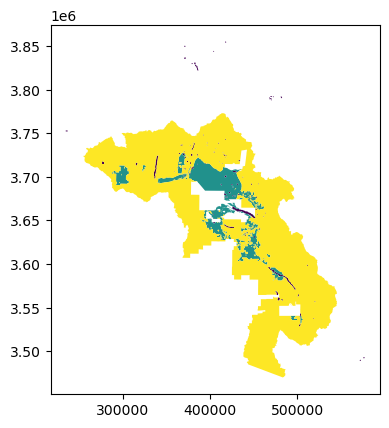

In [10]:
# Read in the shapefile

# filename_shapeile = 'georeg_reproject_fixed.shp'
filename_shapeile = 'CAP_MAR_USFBuffered.shp'
filepath = os.path.join(shapepath_local, filename_shapeile)
shapefile = gp.read_file(filepath)
shapefile.plot(cmap='viridis')


In [11]:
# Define some things about your file

StudyArea = "CAP with MAR Zones (USF Buffered)"
# Naming_col = "Name"
Naming_col = "GSF_OR_USF"
water_designation = cap 

Merging the databases takes a little time - Approximately 3 minutes

In [12]:
# Merge the shapefile with the master database

shapefile = shapefile.to_crs(epsg=26912)
masterdb2 = masterdb.set_crs(epsg=26912)
# For main static database
static_geo = gp.sjoin(masterdb2, shapefile, how="inner", op='intersects')

print(str(filename_mdb_nd) + " and " + str(filename_shapeile) + " join complete.")


c:\Users\det19\.conda\envs\azgwspatialanalysis\lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Master_ADWR_database_noduplicates.shp and CAP_MAR_USFBuffered.shp join complete.


In [13]:
# Pull out the columns you need
# Use this or subbasins:
# reg_list = static_geo[['Combo_ID', Naming_col+'_right','WELL_DEPTH','WELL_TYPE_']]
# Use this or cities:
reg_list = static_geo[['Combo_ID', Naming_col,'WELL_DEPTH','WELL_TYPE_']]
# reg_list

# %% Converting Combo_ID to int
reg_list['Combo_ID'] = reg_list['Combo_ID'].astype(np.int64, errors = 'raise')

C:\Users\det19\AppData\Local\Temp\ipykernel_14804\1936538389.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reg_list['Combo_ID'] = reg_list['Combo_ID'].astype(np.int64, errors = 'raise')


In [14]:
slopes_df.Combo_ID = slopes_df.Combo_ID.astype('int64')

In [16]:
# Merging the Timeseries and the shapefile static database
combo = slopes_df.merge(reg_list, how="inner")
combo.info()

# %% set index to Combo_ID
combo.set_index('Combo_ID', inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1325 entries, 0 to 1324
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Combo_ID    1325 non-null   int64  
 1   Slope       1325 non-null   object 
 2   GSF_OR_USF  1325 non-null   object 
 3   WELL_DEPTH  1325 non-null   float64
 4   WELL_TYPE_  1190 non-null   object 
dtypes: float64(1), int64(1), object(3)
memory usage: 51.9+ KB


In [31]:
combo.to_csv(outputpath_local+"MAR_Slopes.csv")

Plotting

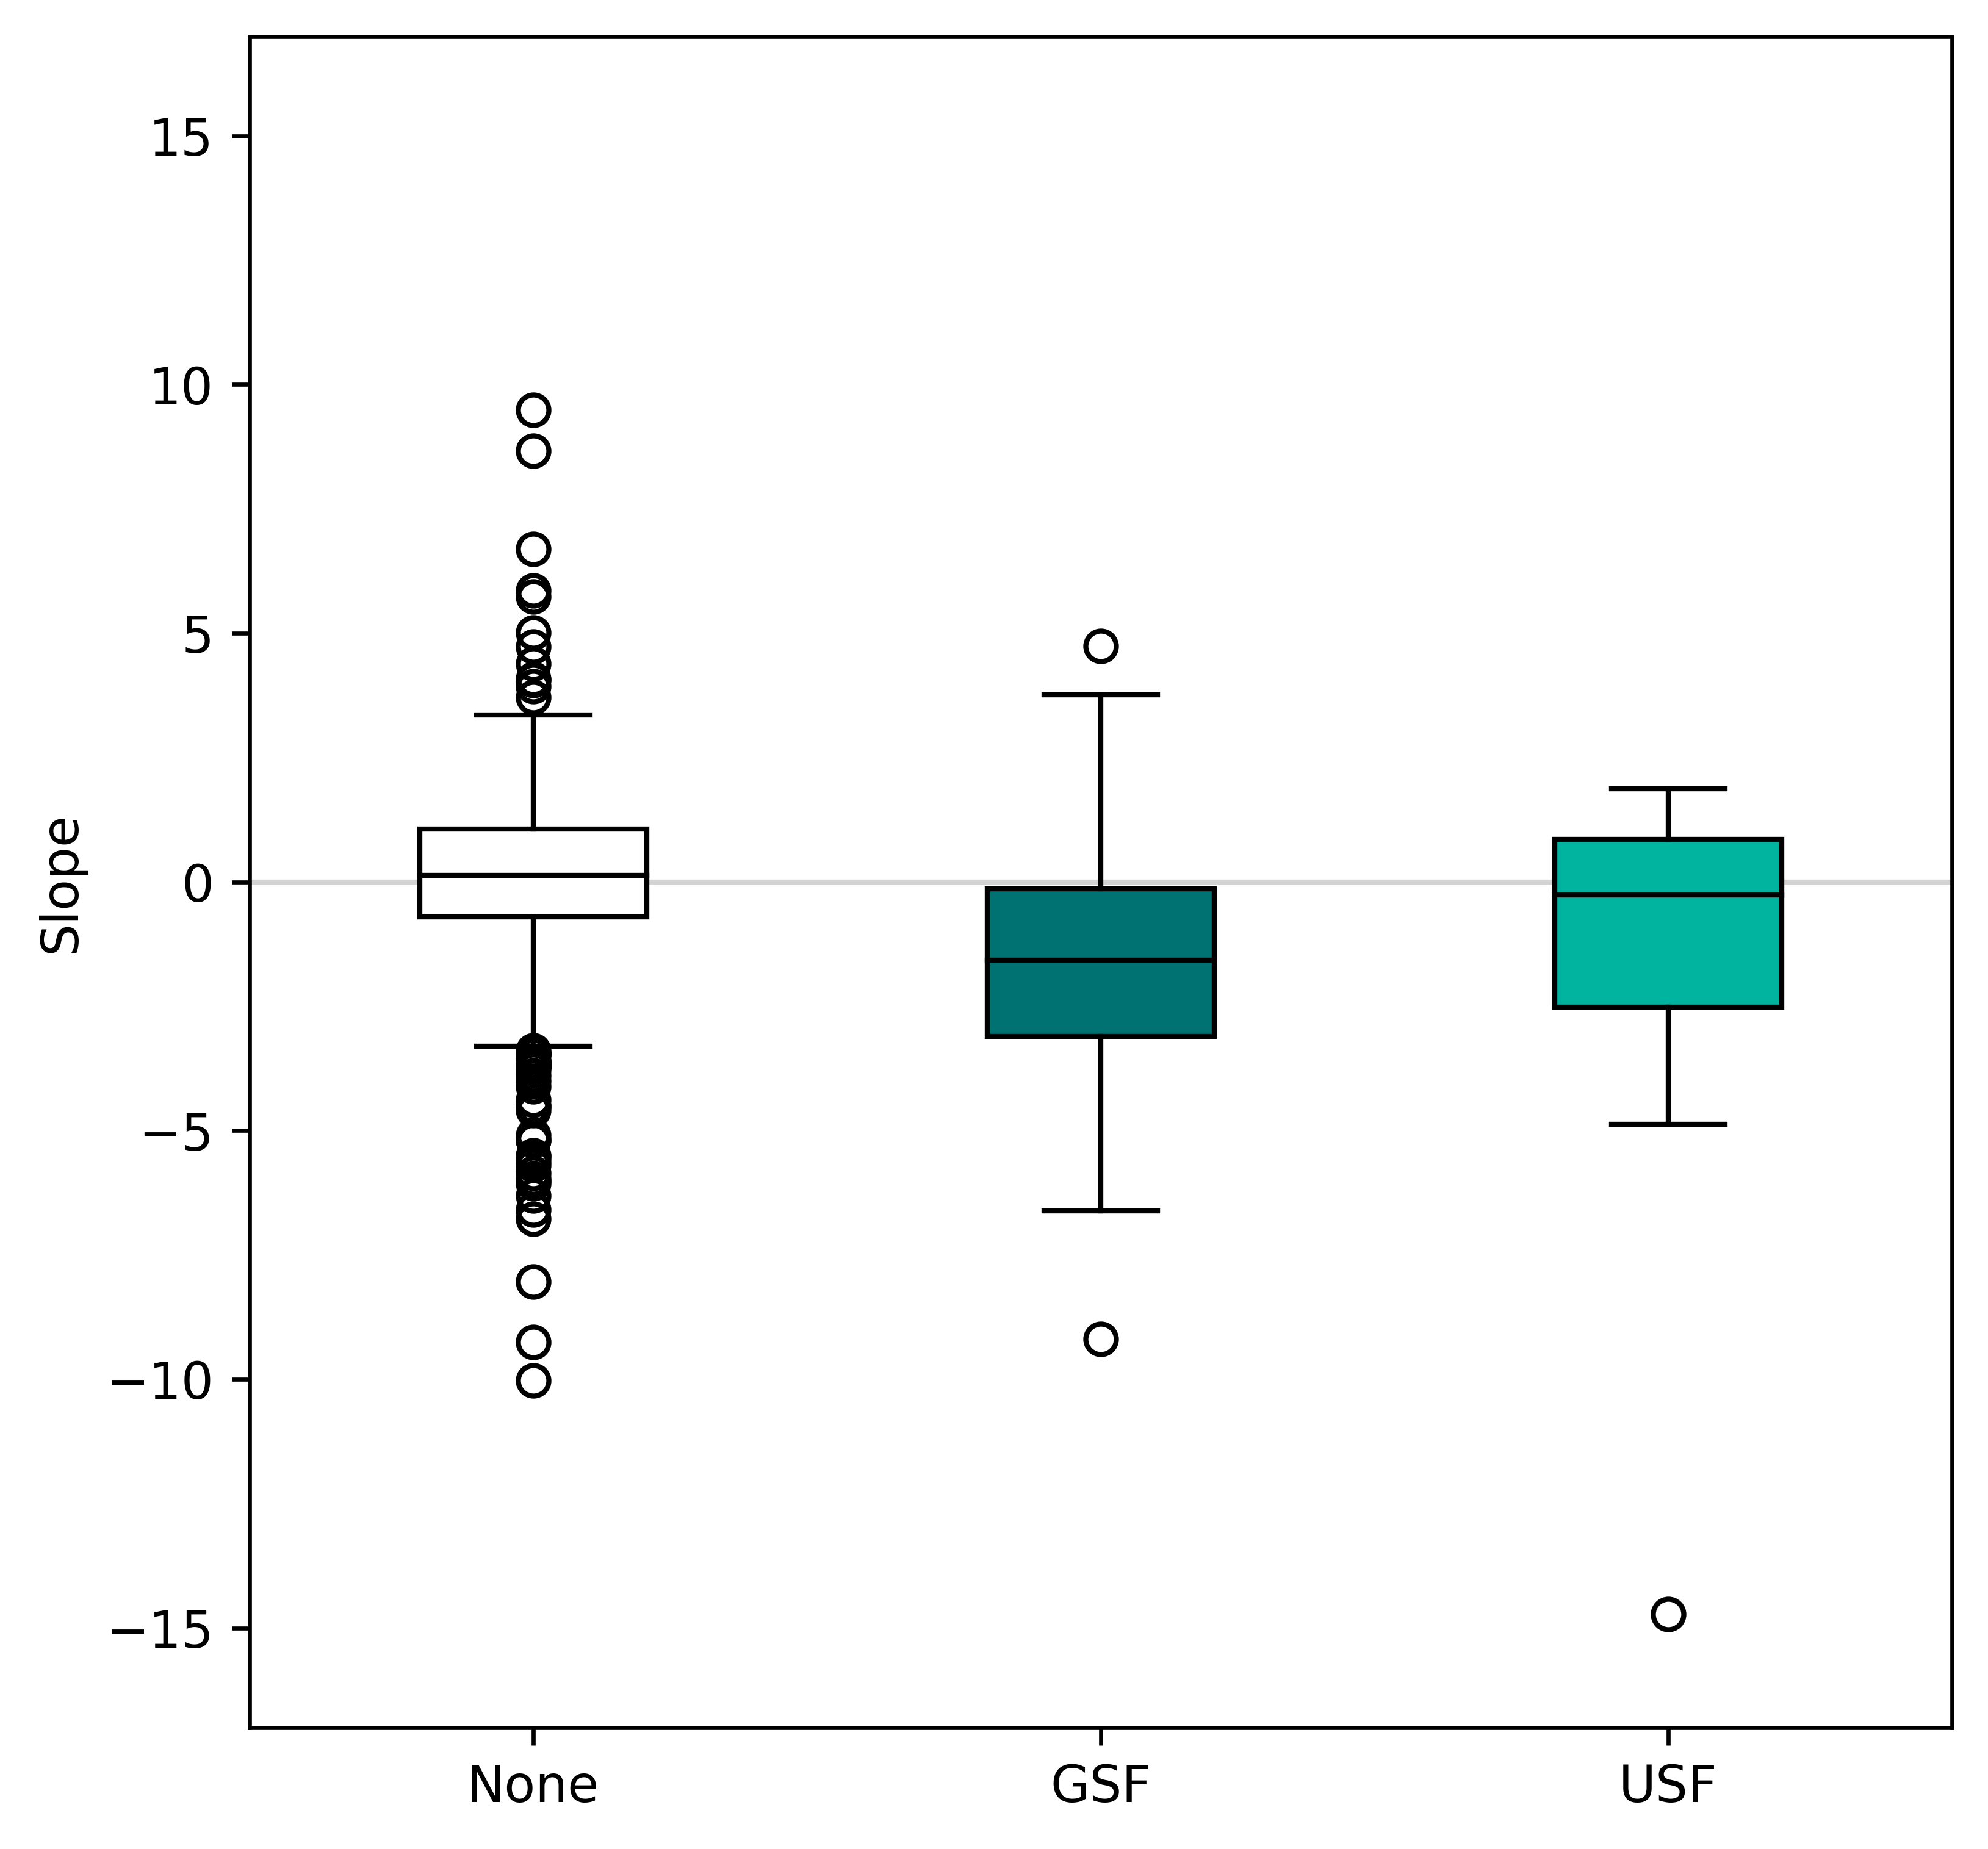

<Figure size 640x480 with 0 Axes>

In [30]:
# Define the desired order of categories
desired_order = ['None','GSF', 'USF']

df = combo.copy()

# Define colors using hexadecimal codes
box_colors = ['white','#007272',
              "#00b49f"]
              # cblind[2]]

# Initialize an empty list to store the box artists
artists = []

fig, ax = plt.subplots(figsize=(6, 6)) 

plt.axhline(y=0, color='lightgrey', linewidth=1)
# Iterate over each category and plot the boxplot
for i, cat in enumerate(desired_order):
    subset = df[df['GSF_OR_USF'] == cat]
    color = box_colors[i]
    artist = plt.boxplot(subset['Slope'], positions=[i], patch_artist=True,
                         boxprops=dict(facecolor=color, color='black'),
                         whiskerprops=dict(color='black'),
                         medianprops=dict(color='black'),
                         capprops=dict(color='black'),
                         widths=0.4)
    artists.append(artist)

# Set xticks and labels
plt.xticks(range(len(desired_order)), desired_order)

plt.ylabel("Slope")
# plt.xlabel("GSF_OR_USF")
# plt.title("b) ")
plt.ylim(-17, 17)
fig.set_dpi(600.0)
plt.show()
# plt.savefig(figurepath+'Figure7b', bbox_inches = 'tight')